In [2]:
import numpy as np 
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import Ridge
import math

%precision %.4f

import warnings
warnings.filterwarnings('ignore')

# Анализ данных

In [3]:
orders = pd.read_csv("orders.csv")
orders_action = pd.read_csv("order_actions.csv")

In [4]:
orders.head()

,Unnamed: 0,id заказа,id экскурсии,Количество билетов,Статус,Дата создания,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство
0,0,1530172259,24829,1,held,2021-07-05 13:52:14.939331,2021-07-07 08:40:50.512257,464.0,deposit,RUB,Mobile
1,1,1530020797,19941,2,cleared,2021-02-02 20:46:13.862124,2021-02-03 14:24:54.313461,972.0,post_pay,USD,Mobile
2,2,1530226540,31065,9,cleared,2021-08-08 19:49:25.746301,2021-08-08 21:51:44.054885,983.0,deposit,RUB,Mobile
3,3,1530328188,28231,1,canceled_by_host,2021-11-01 16:47:48.459655,NaN,93.0,NaN,RUB,Mobile
4,4,1530078146,28632,2,cleared,2021-04-28 17:43:50.731851,2021-04-28 17:47:01.075907,742.0,deposit,RUB,Desktop


In [5]:
orders_action.head()

,Unnamed: 0,id записи,id заказа,Действие,Кто совершил действие,Дата создания
0,1,7448583,1530007987,order_booking_notification_attendee_sms,NaN,2021-01-01 00:11:05.162879
1,2,7448584,1530007987,order_booking_notification_attendee_email,NaN,2021-01-01 00:11:06.329289
2,3,7448585,1530007987,notify_guide_about_booking,NaN,2021-01-01 00:11:06.419906
3,4,7448586,1530007987,order_booking_confirmation_success_sms,NaN,2021-01-01 00:11:07.162839
4,5,7448587,1530007987,order_booking_confirmation_success_email,NaN,2021-01-01 00:11:08.376523


In [6]:
orders.shape

(5000, 11)

In [7]:
orders_action.shape

(47109, 6)

In [8]:
orders = orders.drop(["Unnamed: 0"], axis=1)
orders_action = orders_action.drop(["Unnamed: 0"], axis=1)

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id заказа           5000 non-null   int64  
 1   id экскурсии        5000 non-null   int64  
 2   Количество билетов  5000 non-null   int64  
 3   Статус              5000 non-null   object 
 4   Дата создания       5000 non-null   object 
 5   Дата оплаты         3536 non-null   object 
 6   Цена                5000 non-null   float64
 7   Способ оплаты       4129 non-null   object 
 8   Валюта оплаты       5000 non-null   object 
 9   Устройство          4834 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 390.8+ KB


In [10]:
orders_action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47109 entries, 0 to 47108
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id записи              47109 non-null  int64 
 1   id заказа              47109 non-null  int64 
 2   Действие               47109 non-null  object
 3   Кто совершил действие  21414 non-null  object
 4   Дата создания          47109 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [11]:
orders["Статус"].unique()

array(['held', 'cleared', 'canceled_by_host', 'pending',
       'canceled_by_attendee', 'confirmed', 'deleted',
       'confirmed_by_host', 'confirmed_by_attendee'], dtype=object)

<Axes: xlabel='Статус', ylabel='count'>

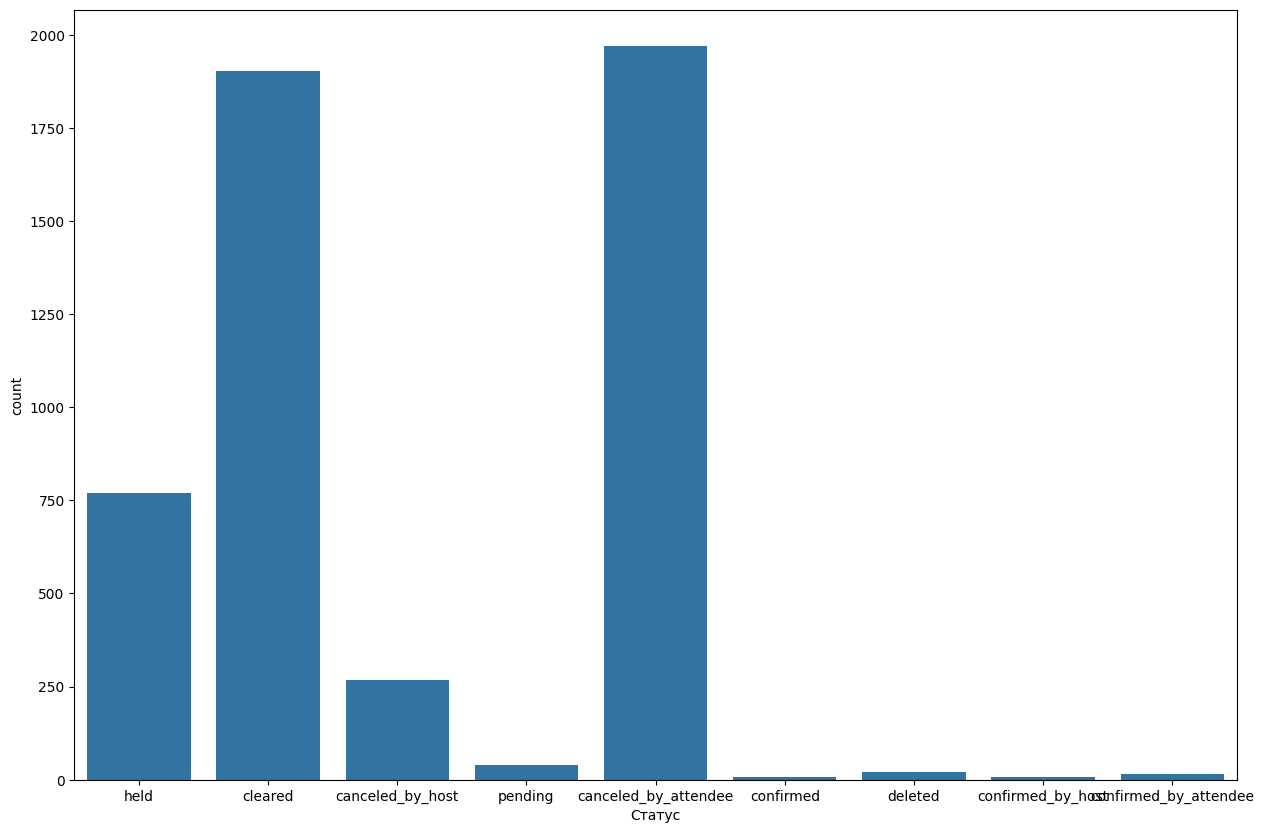

In [12]:
plt.figure(figsize=(15, 10))
sns.countplot(data=orders, x="Статус")

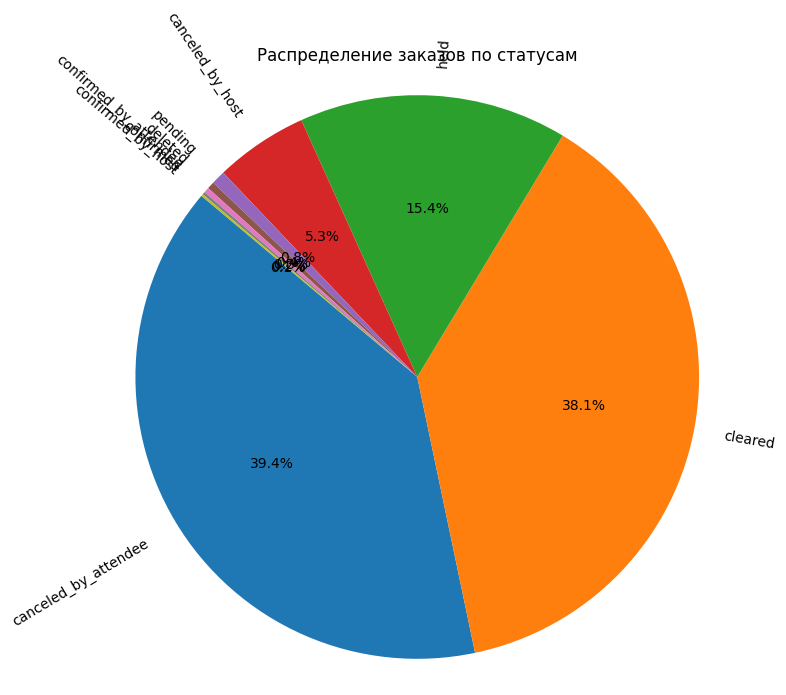

In [150]:
status_counts = orders["Статус"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, rotatelabels=True)
plt.axis('equal')
plt.title('Распределение заказов по статусам')
plt.show()

Видим, что основная доля заказов распределена по четырем статусам: held, cleared, canceled_by_attendee, canceled_by_host

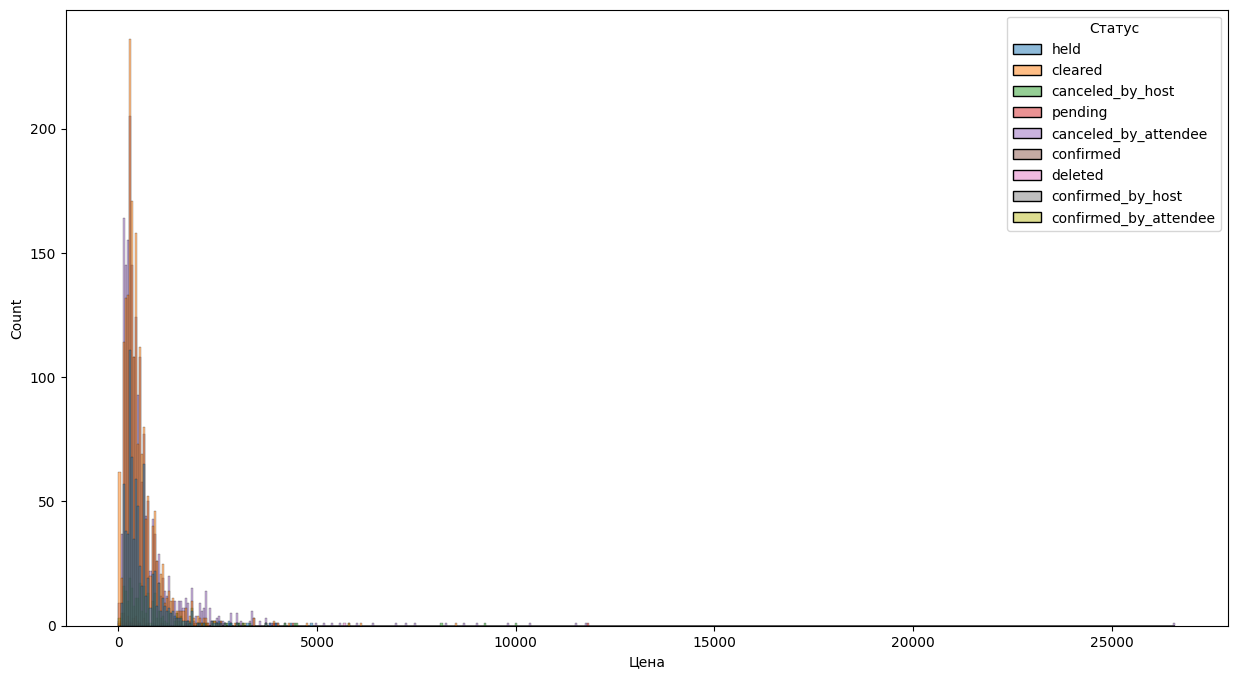

In [14]:
plt.figure(figsize=(15, 8))
sns.histplot(data=orders, x="Цена", hue="Статус");

Распределение скошено в левую сторону и похоже на гамма или логнормальное распределение

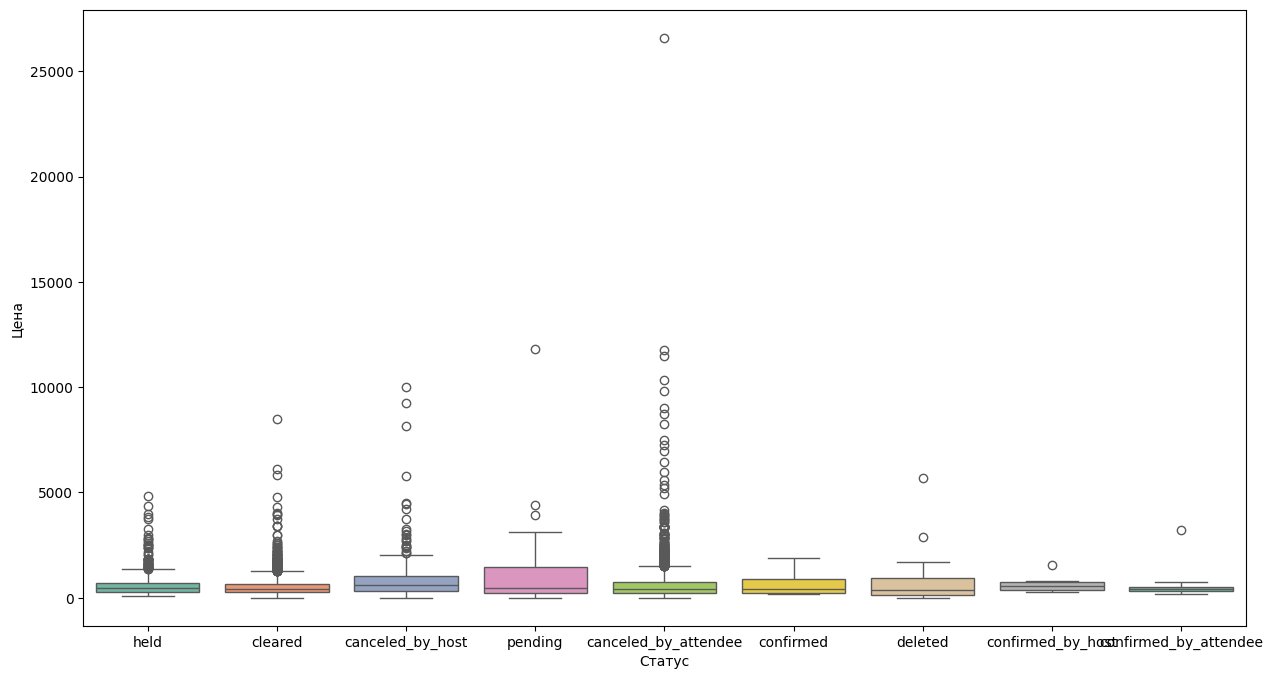

In [15]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=orders, x="Статус", y="Цена", palette = 'Set2');

В ценах есть выбросы. Наиболее дорогие заказы находятся на рассмотрении

In [118]:
full = orders.merge(orders_action, on="id заказа", how='inner')

In [119]:
full.head()

,id заказа,id экскурсии,Количество билетов,Статус,Дата создания_x,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство,id записи,Действие,Кто совершил действие,Дата создания_y
0,1530172259,24829,1,held,2021-07-05 13:52:14.939331,2021-07-07 08:40:50.512257,464.0,deposit,RUB,Mobile,9733764,order_booking_confirmation_success_sms,NaN,2021-07-05 13:54:39.546282
1,1530172259,24829,1,held,2021-07-05 13:52:14.939331,2021-07-07 08:40:50.512257,464.0,deposit,RUB,Mobile,9733768,order_booking_confirmation_success_email,NaN,2021-07-05 13:54:40.934848
2,1530172259,24829,1,held,2021-07-05 13:52:14.939331,2021-07-07 08:40:50.512257,464.0,deposit,RUB,Mobile,9733722,order_booking_notification_attendee_sms,NaN,2021-07-05 13:52:43.666605
3,1530172259,24829,1,held,2021-07-05 13:52:14.939331,2021-07-07 08:40:50.512257,464.0,deposit,RUB,Mobile,9733723,order_booking_notification_attendee_email,NaN,2021-07-05 13:52:44.982751
4,1530172259,24829,1,held,2021-07-05 13:52:14.939331,2021-07-07 08:40:50.512257,464.0,deposit,RUB,Mobile,9733724,notify_guide_about_booking,NaN,2021-07-05 13:52:45.093909


In [120]:
full.shape

(47109, 14)

In [121]:
full["Дата создания_x"][0]

'2021-07-05 13:52:14.939331'

Конвертируем даты из str в date_time

In [122]:
full["Дата создания_x"] = pd.to_datetime(full["Дата создания_x"])
full["Дата создания_y"] = pd.to_datetime(full["Дата создания_y"])

In [123]:
full["Дата создания_x"][0]

Timestamp('2021-07-05 13:52:14.939331')

In [124]:
time = full.loc[full["Действие"] == "order_cancel_as_attendee"]

In [125]:
time

,id заказа,id экскурсии,Количество билетов,Статус,Дата создания_x,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство,id записи,Действие,Кто совершил действие,Дата создания_y
53,1530158479,35532,2,canceled_by_attendee,2021-06-24 17:07:13.550835,NaN,927.0,NaN,RUB,Mobile,9551022,order_cancel_as_attendee,user,2021-06-25 14:35:18.107225
83,1530120445,15713,1,canceled_by_attendee,2021-06-01 14:49:42.753923,NaN,184.0,NaN,RUB,Mobile,9023221,order_cancel_as_attendee,user,2021-06-02 11:16:04.330606
115,1530174888,32460,3,canceled_by_attendee,2021-07-07 12:15:02.304358,2021-07-07 12:17:03.868453,940.0,post_pay,RUB,Desktop,10858603,order_cancel_as_attendee,user,2021-08-24 10:31:02.975665
117,1530288335,26577,2,canceled_by_attendee,2021-09-22 11:48:28.719454,NaN,594.0,NaN,RUB,Desktop,11396990,order_cancel_as_attendee,user,2021-09-22 11:56:54.922400
120,1530080996,24150,2,canceled_by_attendee,2021-04-30 16:35:12.975843,NaN,571.0,NaN,RUB,Mobile,8909550,order_cancel_as_attendee,user,2021-05-26 18:45:25.162644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46999,1530045356,17022,1,canceled_by_attendee,2021-03-23 08:29:14.683734,NaN,130.0,NaN,RUB,Mobile,7993773,order_cancel_as_attendee,user,2021-03-25 17:57:30.007024
47007,1530348909,30344,1,canceled_by_attendee,2021-12-07 16:06:20.183314,NaN,538.0,full_pay,RUB,Desktop,12734233,order_cancel_as_attendee,admin,2022-01-08 13:20:02.048917
47065,1530048142,29893,2,canceled_by_attendee,2021-03-26 14:45:40.605166,2021-03-26 14:47:20.312489,1676.0,post_pay,EUR,Desktop,8784678,order_cancel_as_attendee,user,2021-05-17 20:18:56.904500
47069,1530359578,22114,2,canceled_by_attendee,2021-12-25 09:57:04.226795,NaN,334.0,deposit,RUB,Desktop,12471171,order_cancel_as_attendee,admin,2021-12-26 13:30:23.230316


In [126]:
time_attendee = time["Дата создания_y"] - time["Дата создания_x"]

In [127]:
time_attendee.mean()

Timedelta('19 days 07:16:40.218984111')

In [128]:
time = full.loc[full["Действие"] == "order_cancel_as_host"]

In [129]:
time_attendee = time["Дата создания_y"] - time["Дата создания_x"]

In [130]:
time_attendee.mean()

Timedelta('14 days 19:12:15.386711771')

Среднее время между временем заказа и отмены туристом > 19 дней, гидом > 14

In [131]:
succesful_orders_confirmed = full.loc[full["Статус"].isin(["confirmed"])]
succesful_orders_cleared = full.loc[full["Статус"].isin(["cleared"])]
succesful_orders_held = full.loc[full["Статус"].isin(["held"])]

In [132]:
succesful_orders_confirmed.groupby("id заказа").count()

,id экскурсии,Количество билетов,Статус,Дата создания_x,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство,id записи,Действие,Кто совершил действие,Дата создания_y
id заказа,,,,,,,,,,,,,
1530026444,11,11,11,11,11,11,11,11,11,11,11,4,11
1530036577,11,11,11,11,11,11,11,11,11,11,11,4,11
1530104918,16,16,16,16,16,16,16,16,16,16,16,7,16
1530198732,8,8,8,8,8,8,8,8,8,8,8,5,8
1530214071,11,11,11,11,11,11,11,11,11,11,11,4,11
1530215918,10,10,10,10,10,10,10,10,10,10,10,3,10
1530225907,11,11,11,11,11,11,11,11,11,11,11,3,11
1530260579,12,12,12,12,12,12,12,12,12,12,12,4,12


In [133]:
confirmed = succesful_orders_confirmed.groupby("id заказа").count()["id экскурсии"].mean()

In [134]:
confirmed

11.2500

In [135]:
succesful_orders_cleared.groupby("id заказа").count()

,id экскурсии,Количество билетов,Статус,Дата создания_x,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство,id записи,Действие,Кто совершил действие,Дата создания_y
id заказа,,,,,,,,,,,,,
1530008115,11,11,11,11,11,11,11,11,11,11,11,4,11
1530008133,3,3,3,3,0,3,3,3,0,3,3,2,3
1530008139,9,9,9,9,9,9,9,9,9,9,9,3,9
1530008152,14,14,14,14,14,14,14,14,14,14,14,6,14
1530008269,8,8,8,8,0,8,0,8,8,8,8,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530363611,4,4,4,4,0,4,4,4,0,4,4,3,4
1530363772,9,9,9,9,9,9,9,9,9,9,9,3,9
1530364293,11,11,11,11,11,11,11,11,11,11,11,4,11


In [136]:
cleared = succesful_orders_cleared.groupby("id заказа").count()["id экскурсии"].mean()

In [137]:
cleared

11.7232

In [138]:
succesful_orders_held.groupby("id заказа").count()

,id экскурсии,Количество билетов,Статус,Дата создания_x,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство,id записи,Действие,Кто совершил действие,Дата создания_y
id заказа,,,,,,,,,,,,,
1530008191,11,11,11,11,11,11,11,11,11,11,11,5,11
1530010430,17,17,17,17,17,17,17,17,17,17,17,8,17
1530010861,12,12,12,12,12,12,12,12,12,12,12,5,12
1530012868,5,5,5,5,5,5,5,5,5,5,5,4,5
1530013196,4,4,4,4,4,4,4,4,4,4,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530364042,17,17,17,17,17,17,17,17,17,17,17,8,17
1530364395,12,12,12,12,12,12,12,12,12,12,12,5,12
1530364763,14,14,14,14,14,14,14,14,14,14,14,5,14


In [139]:
held = succesful_orders_held.groupby("id заказа").count()["id экскурсии"].mean()

In [140]:
held

12.1313

В среднем заказе происходит примерно 11-12 действий, больше всего действий в заказах со статусом held, меньше - confirmed

In [141]:
succesful_orders = full.loc[full["Статус"].isin(["confirmed", "cleared", "held"])]

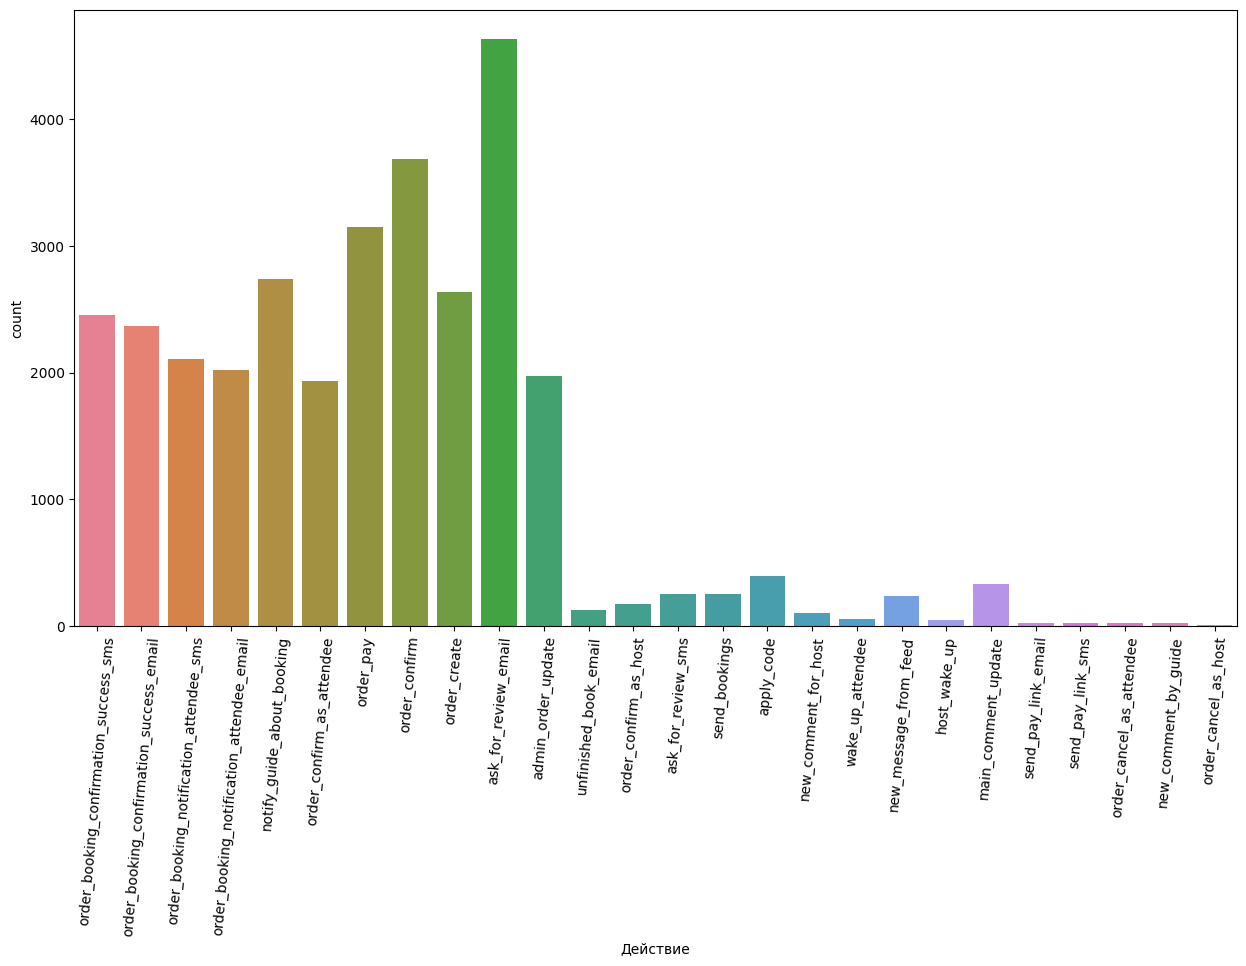

In [142]:
plt.figure(figsize=(15, 8))
sns.countplot(data=succesful_orders, x="Действие", hue="Действие")
plt.xticks(rotation=85)
plt.show()

Наиболее популярным действием является запрос отзыва об экскурсии по почте, это дейтсвие похоже на то, которое можно автоматизировать. Например, отправлять отзыв после оплаты или подтверждения заказа автоматически

In [143]:
time_pay = succesful_orders["Дата создания_y"] - succesful_orders["Дата создания_x"]

In [144]:
time_pay.mean()

Timedelta('7 days 08:19:33.706624932')

Среднее время между созданием успешного заказа и его оплатой составляет от 7 до 8 дней

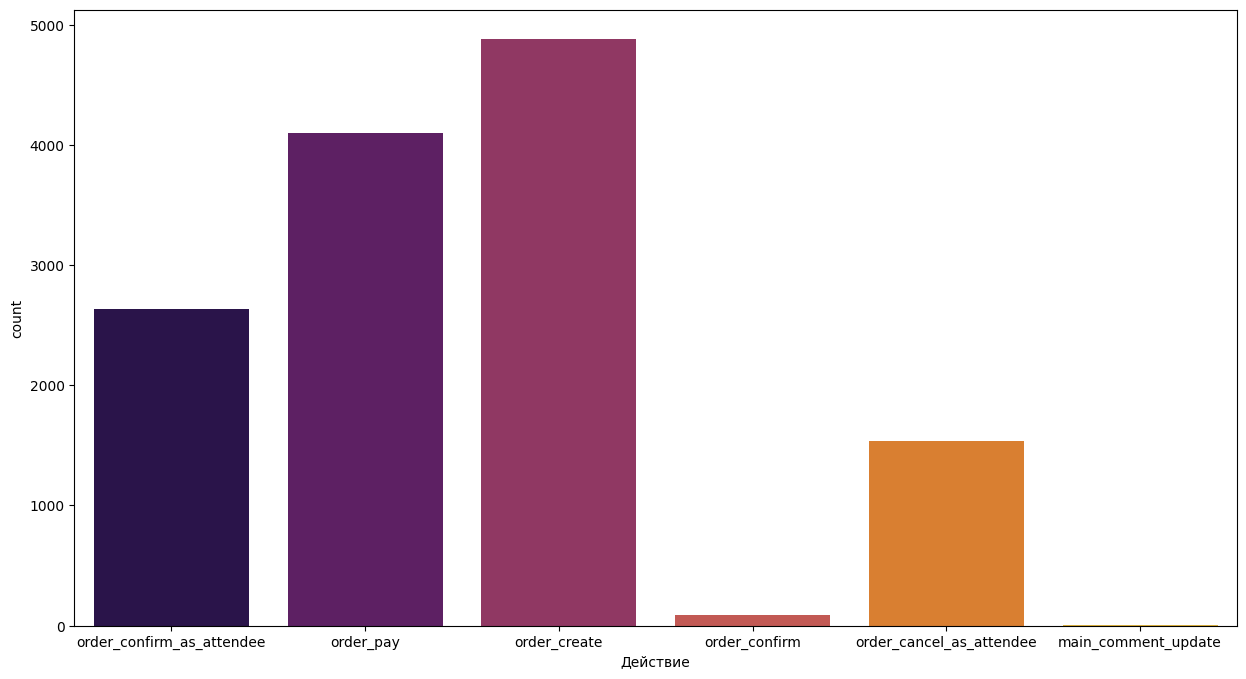

In [145]:
plt.figure(figsize=(15, 8))
sns.countplot(data=full.loc[full["Кто совершил действие"] == "user"], x="Действие", palette="inferno")
plt.show()

Наиболее попклярными действиями пользователя являются создание, подтверждение и оплата заказа. Также почти 2к заказов туристы отменяют сами.

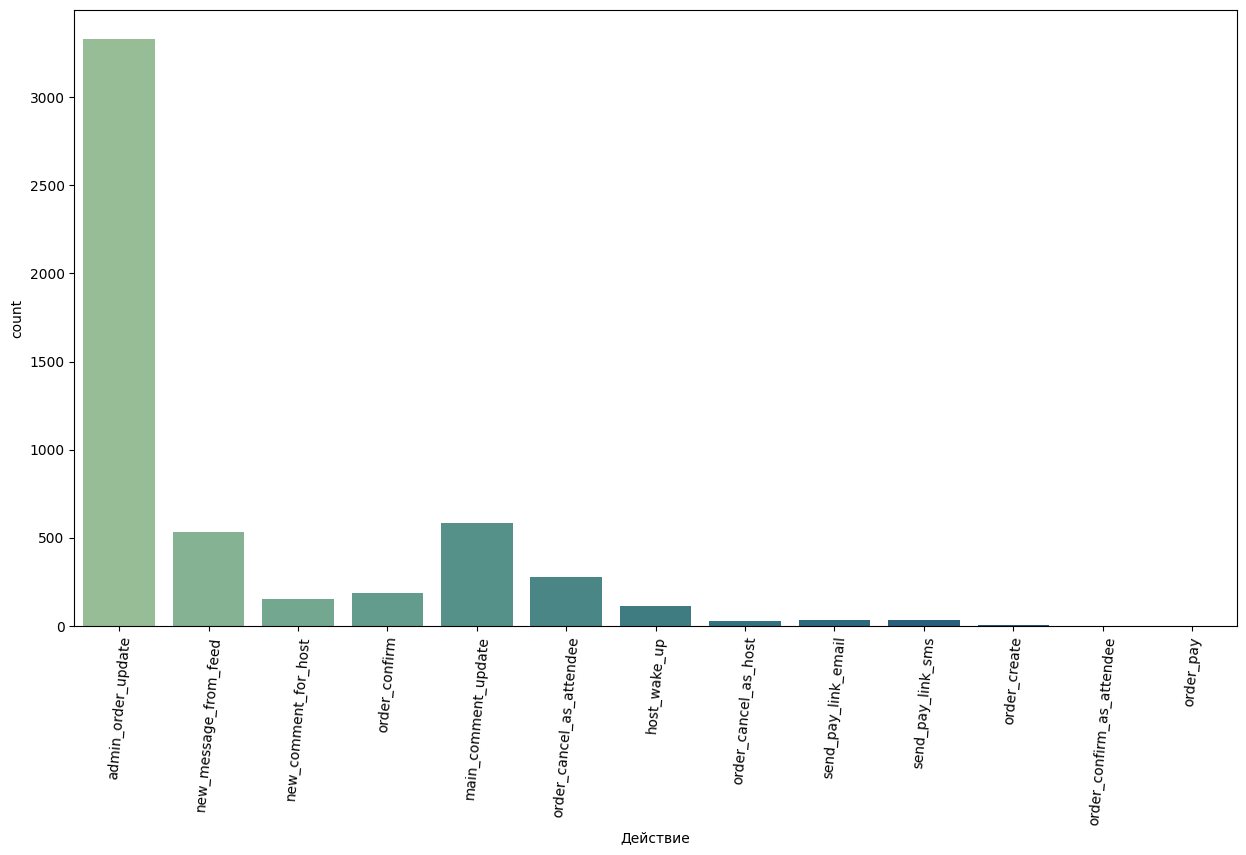

In [146]:
plt.figure(figsize=(15, 8))
sns.countplot(data=full.loc[full["Кто совершил действие"] == "admin"], x="Действие", palette="crest")
plt.xticks(rotation=85)
plt.show()

Самое популярное действие администраторов - обновление заказа, более 3к. Остальных дейтсвий не так много, обычне менее 500. Наиболее популярные из них - обновление комментариев в заказе.

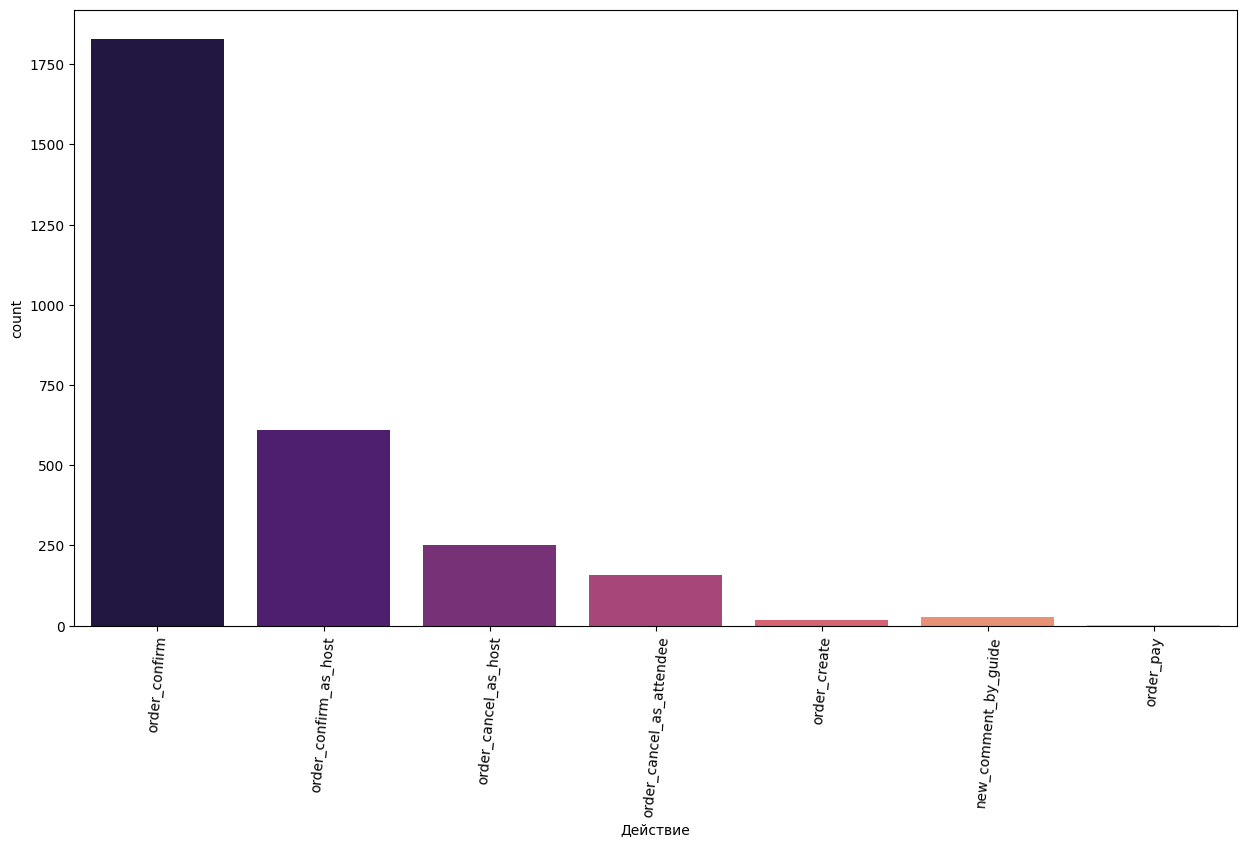

In [147]:
plt.figure(figsize=(15, 8))
sns.countplot(data=full.loc[full["Кто совершил действие"] == "host"], x="Действие", palette="magma")
plt.xticks(rotation=85)
plt.show()

Гиды чаще всего подтверждают заказы

# Дополнительный анализ

In [153]:
orders["Валюта оплаты"].unique()

array(['RUB', 'USD', 'EUR', 'UAH'], dtype=object)

Как мы помним есть один заказ с большим выбросом в цене, посмотрим на него и попробуем проанализировать цены без данного заказа

In [158]:
orders.loc[orders["Цена"] == orders["Цена"].max()]

,id заказа,id экскурсии,Количество билетов,Статус,Дата создания,Дата оплаты,Цена,Способ оплаты,Валюта оплаты,Устройство
1363,1530229402,35534,6,canceled_by_attendee,2021-08-10 13:15:48.313517,NaN,26600.0,deposit,RUB,Desktop


Заказ на сумму 26600 был отклонен 

<Axes: ylabel='Цена'>

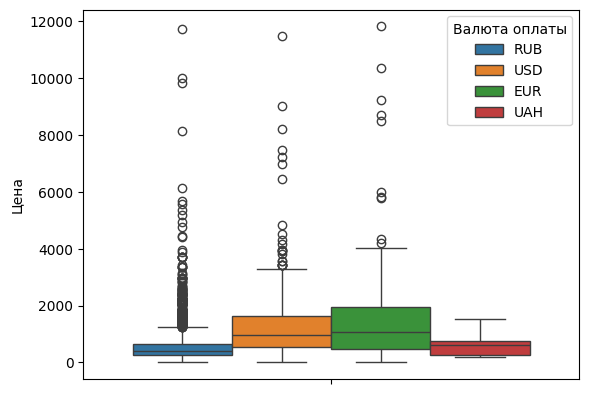

In [159]:
sns.boxplot(data=orders[orders["Цена"] != 26600.0], y="Цена", hue="Валюта оплаты")

Самые дорогие заказы обычно в долларах и евро, самые дешевые - в рублях и гривнах

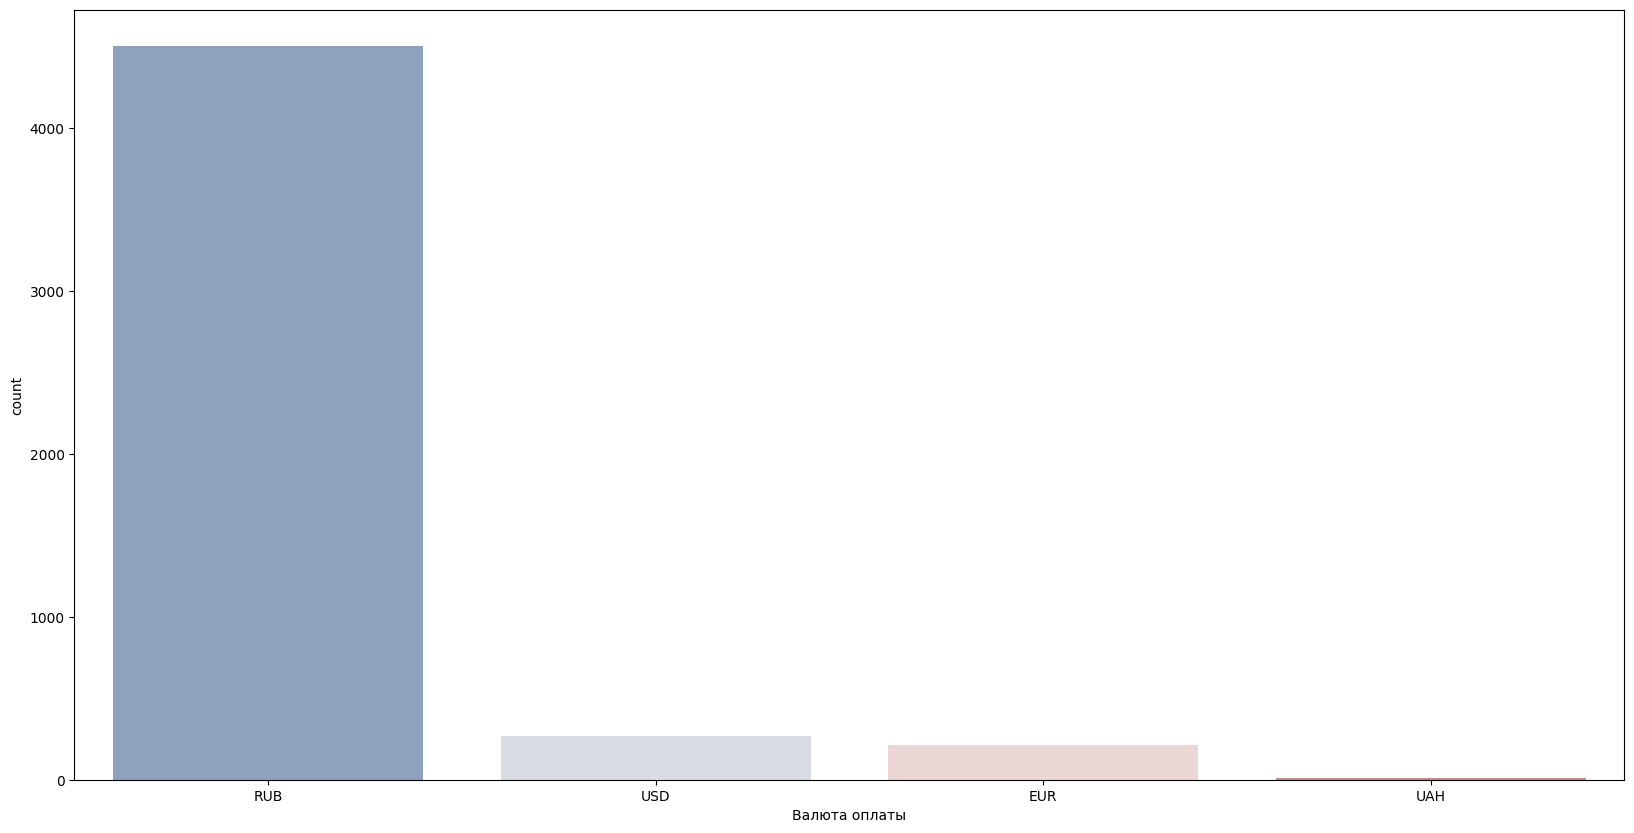

In [172]:
plt.figure(figsize=(20, 10))
sns.countplot(data=orders[orders["Цена"] != 26600.0], x="Валюта оплаты", palette="vlag");

Однако, большинство заказов совершаются именно в рублях

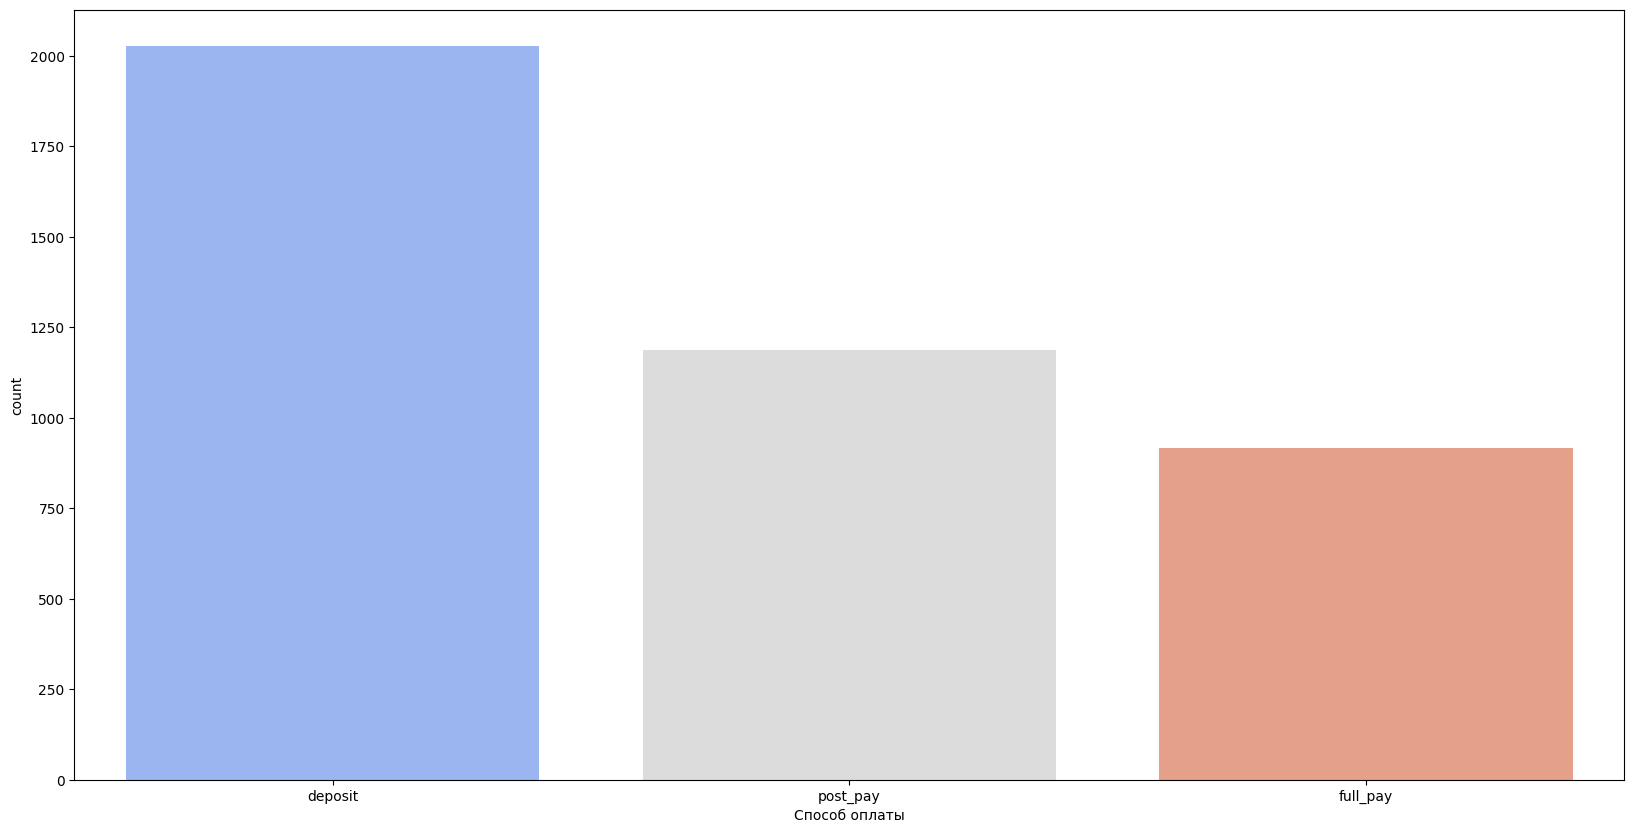

In [175]:
plt.figure(figsize=(20, 10))
sns.countplot(data=orders[orders["Цена"] != 26600.0], x="Способ оплаты", palette="coolwarm");

У большинства заказов вносится предоплата, меьеше всего оплачиают сразу полностью

In [176]:
orders["Устройство"].unique()

array(['Mobile', 'Desktop', 'Phablet', 'Tablet', nan, 'TV'], dtype=object)

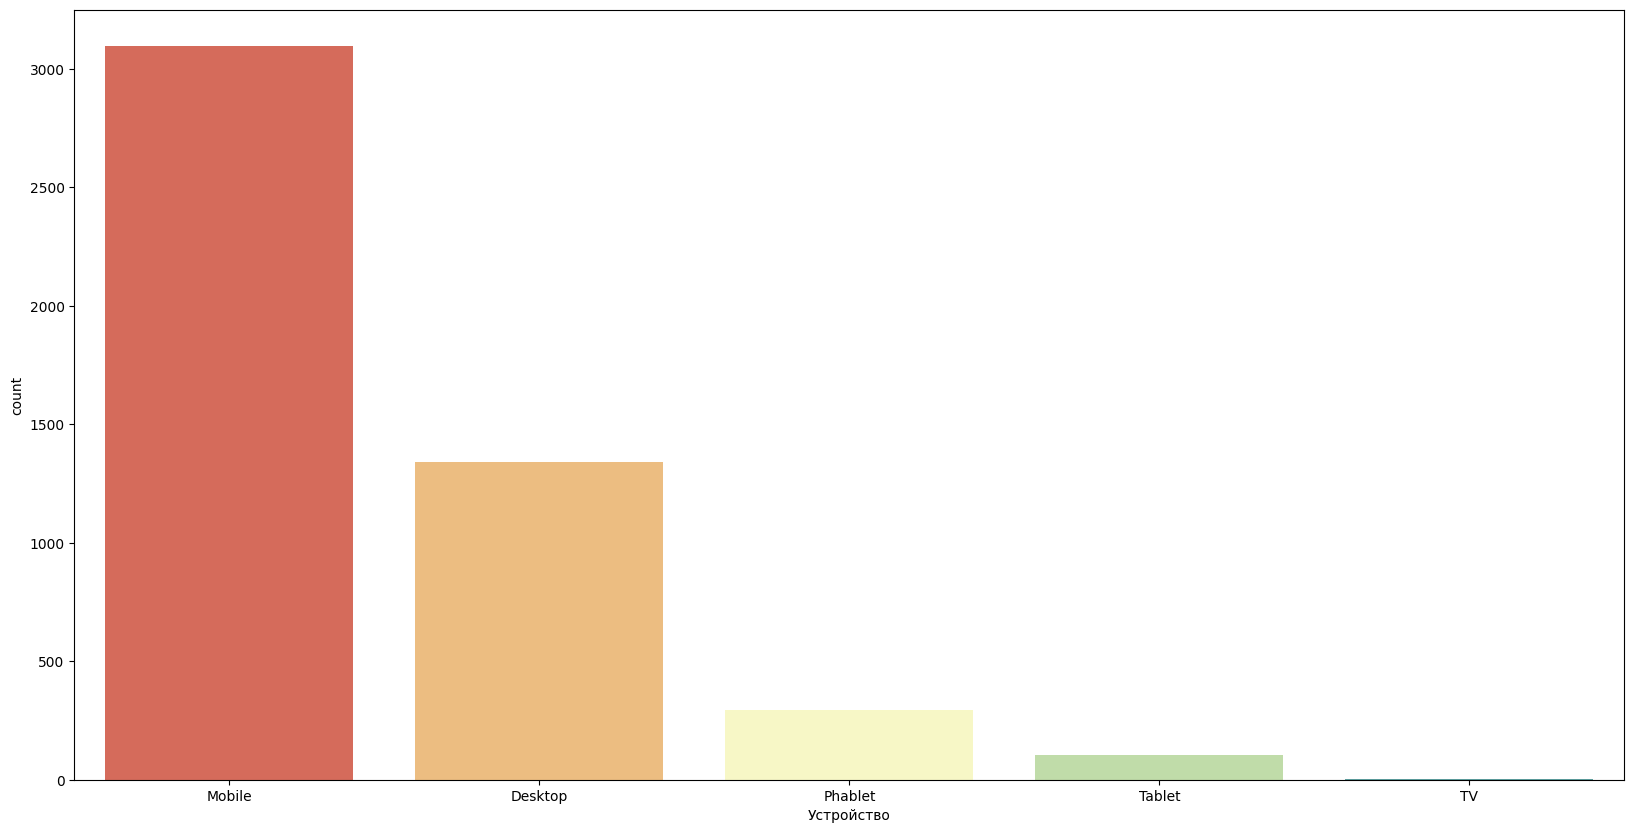

In [177]:
plt.figure(figsize=(20, 10))
sns.countplot(data=orders, x="Устройство", palette="Spectral");

Много заказов совершается с мобильных устройств и планшетов, следовательно при развитии продукта мобильной версии приложения надо выделить первостепенную роль 

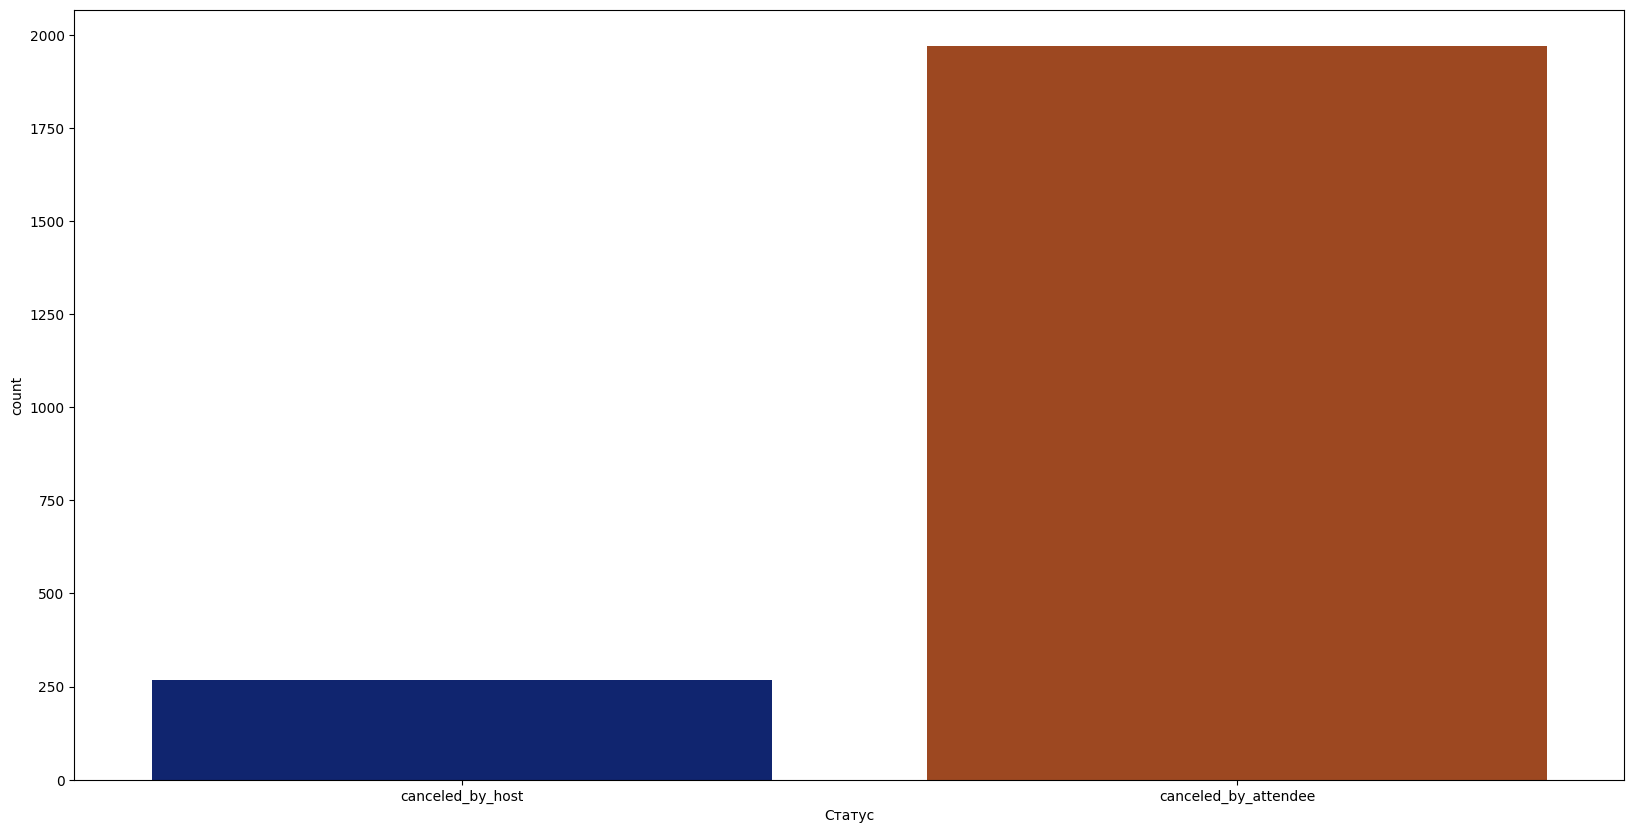

In [181]:
plt.figure(figsize=(20, 10))
sns.countplot(data=orders.loc[orders["Статус"].isin(["canceled_by_attendee", "canceled_by_host"])], x="Статус", palette="dark");

В основном, заказы отменют сами туристы

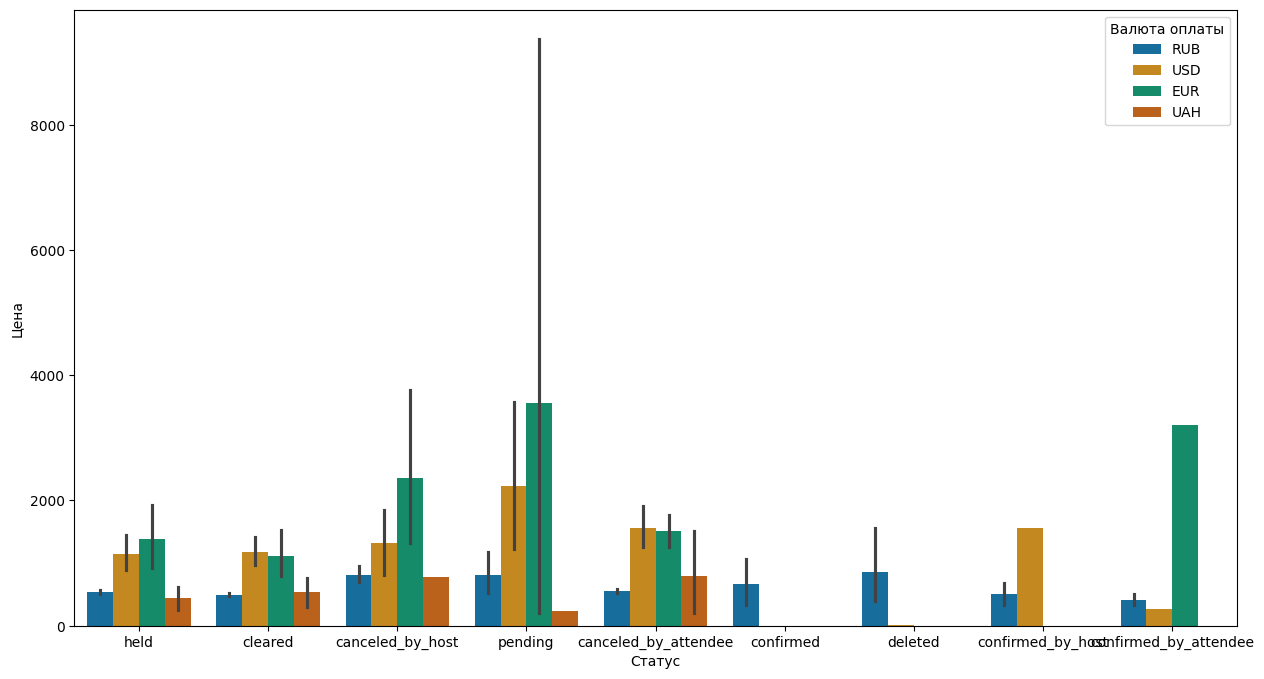

In [186]:
plt.figure(figsize=(15, 8))
sns.barplot(data=orders[orders["Цена"] != 26600.0], y="Цена", x="Статус", hue="Валюта оплаты", palette="colorblind");

Все успешные заказы(held, cleared, confirmed) - наименее дорогстоящие. Крупные заказы находятся в рассмотрении или отменены гидом